# Visualization Utils - Presentation

In [2]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import pandas.util.testing as tm

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph, from_scipy_sparse_matrix, to_scipy_sparse_matrix
from torch_geometric.utils import is_undirected, to_undirected
from scipy.sparse import csr_matrix

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax

from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv

import sys, os
sys.path.insert(0, '/cluster/home/kamara/Explain')
sys.path.insert(0, '/cluster/home/kamara/Explain/code')

import json
import pickle
import time
from datetime import datetime
import argparse
import random
import itertools

from dataset import *
from evaluate import *
from explainer import *
from dataset.syn_utils.gengraph import gen_syn1
#from gnn import GcnEncoderNode, train, gnn_scores, get_labels
from utils.gen_utils import get_subgraph, from_edge_index_to_adj, from_adj_to_edge_index
from utils.io_utils import check_dir
from utils.parser_utils import arg_parse



/tmp/ipykernel_13103/792133964.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
print(plt.get_backend())

module://matplotlib_inline.backend_inline


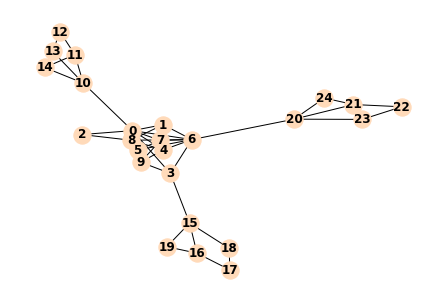

In [33]:
G, labels, _ = gen_syn1(nb_shapes=3, width_basis=10, feature_generator=None, m=5)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color="peachpuff", with_labels=True, font_weight='bold')

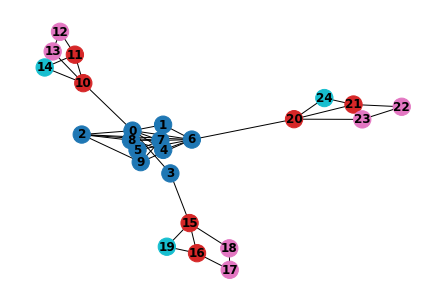

In [34]:
G, labels, _ = gen_syn1(nb_shapes=3, width_basis=10, feature_generator=None, m=5)
nx.draw(G, pos, cmap=plt.get_cmap('tab10'), node_color=labels, with_labels=True, font_weight='bold')

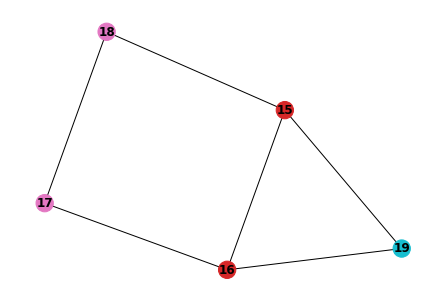

In [24]:
res = np.array([15, 16, 17, 18, 19])
k = G.subgraph(res)
nx.draw(k, cmap=plt.get_cmap('tab10'), node_color=np.take(labels, res), with_labels=True, font_weight='bold', vmin=0, vmax=3)

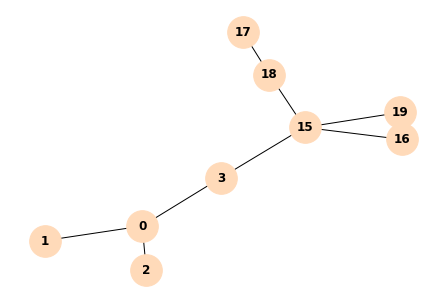

In [57]:
res = np.array([0, 1, 2, 3, 15, 16, 17, 18, 19])
k = nx.Graph(G.subgraph(res))
k.remove_edge(16, 17)
pos = nx.spring_layout(k)
nx.draw(k, pos, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', vmin=0, vmax=3)

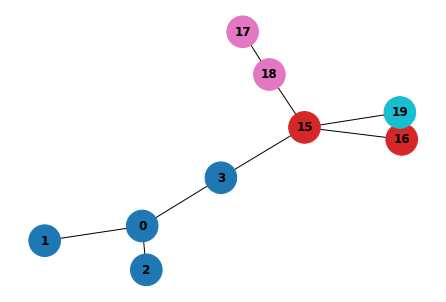

In [58]:
nx.draw(k, pos, cmap=plt.get_cmap('tab10'), node_color=np.take(labels, res), node_size=1000, with_labels=True, font_weight='bold', vmin=0, vmax=3)

## Mask transformation

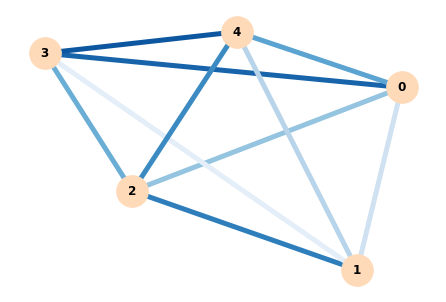

In [19]:
# Set up weighted adjacency matrix
A = np.array([[0, 0.2, 0.4, 0.8, 0.55],
              [0.2, 0, 0.7, 0.1, 0.3],
              [0.4, 0.7, 0, 0.5, 0.65],
             [0.8, 0.1, 0.5, 0, 0.85],
             [0.55, 0.3, 0.65, 0.85, 0]])

# Create DiGraph from A
G = nx.from_numpy_matrix(A, create_using=nx.Graph)

# Use spring_layout to handle positioning of graph
layout = nx.spring_layout(G)
# Get weights of each edge and assign to labels
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())

# Draw the graph using the layout - with_labels=True if you want node labels.
nx.draw(G, layout, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', edgelist=edges, edge_color=weights,
            width=5,
            edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)




### Sparsity

### Threshold

In [20]:
threshold = 0.5
A_sparsity = np.where(A > threshold, A, 0)

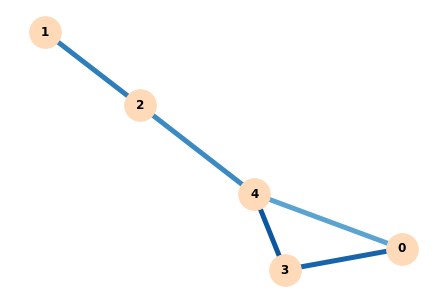

In [21]:
# Create DiGraph from A
G = nx.from_numpy_matrix(A_sparsity, create_using=nx.Graph)

# Use spring_layout to handle positioning of graph
layout = nx.spring_layout(G)
# Get weights of each edge and assign to labels
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())

# Draw the graph using the layout - with_labels=True if you want node labels.
nx.draw(G, layout, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', edgelist=edges, edge_color=weights,
            width=5,
            edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)